In [ ]:
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn as skl
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.1.3'

os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:13 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [91.7 kB]
Hit:14 http:

In [ ]:
# Connect to Postgres
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2022-09-10 23:26:47--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  5.46MB/s    in 0.2s    

2022-09-10 23:26:48 (5.46 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [ ]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [ ]:
# Read the data from s3 bucket
from pyspark import SparkFiles
# Load in amazon luggage.tsv from S3 into a DataFrame
url = "https://shoppingproject4.s3.amazonaws.com/marketing_campaign.csv"
spark.sparkContext.addFile(url)

df = spark.read.option('header', 'true').csv(SparkFiles.get("marketing_campaign.csv"), inferSchema=True, sep=',', timestampFormat="yyyy-mm-dd")
df.show(10)

+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
|  ID|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+----------

In [ ]:
# read data into a pandas dataframe
pandas_df = df.toPandas() 
pandas_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,4/9/12,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,8/3/14,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10/2/14,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
# Check for null values
for column in pandas_df.columns:
    print(f"Column {column} has {pandas_df[column].isnull().sum()} null values")

Column ID has 0 null values
Column Year_Birth has 0 null values
Column Education has 0 null values
Column Marital_Status has 0 null values
Column Income has 24 null values
Column Kidhome has 0 null values
Column Teenhome has 0 null values
Column Dt_Customer has 0 null values
Column Recency has 0 null values
Column MntWines has 0 null values
Column MntFruits has 0 null values
Column MntMeatProducts has 0 null values
Column MntFishProducts has 0 null values
Column MntSweetProducts has 0 null values
Column MntGoldProds has 0 null values
Column NumDealsPurchases has 0 null values
Column NumWebPurchases has 0 null values
Column NumCatalogPurchases has 0 null values
Column NumStorePurchases has 0 null values
Column NumWebVisitsMonth has 0 null values
Column AcceptedCmp3 has 0 null values
Column AcceptedCmp4 has 0 null values
Column AcceptedCmp5 has 0 null values
Column AcceptedCmp1 has 0 null values
Column AcceptedCmp2 has 0 null values
Column Complain has 0 null values
Column Z_CostContact 

In [ ]:
# Drop all null values
new_df = pandas_df.dropna()
new_df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,4/9/12,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,8/3/14,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10/2/14,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10/6/14,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


In [ ]:
# Find duplicate entries
print(f"Duplicate entries: {new_df.duplicated().sum()}")

Duplicate entries: 0


In [ ]:
# Drop columns
_df = new_df.drop(['Dt_Customer'], axis=1)
_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,58,635,88,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,38,11,1,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,26,426,49,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,26,11,4,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,94,173,43,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
# Transform categorical values to numerical
def changeeducation(edu):
    if edu == "Graduation":
        return 1
    elif edu == 'PhD':
        return 2
    elif edu == 'Master':
        return 3
    elif edu == 'Basic':
        return 4
    else:
        return 0
_df["Education"] = _df["Education"].apply(changeeducation)
_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,1,Single,58138.0,0,0,58,635,88,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,1,Single,46344.0,1,1,38,11,1,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,1,Together,71613.0,0,0,26,426,49,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,1,Together,26646.0,1,0,26,11,4,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,2,Married,58293.0,1,0,94,173,43,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
# Transform categorical values to numerical
def changestatus(marital):
    if marital == "Single":
        return 1
    elif marital == 'Together':
        return 2
    elif marital == 'Married':
        return 2
    elif marital == 'Divorced':
        return 1
    elif marital == 'Widow':
        return 1
    elif marital == 'Alone':
        return 1
    elif marital == 'Absurd':
        return 1
    else:
        return 0

_df["Marital_Status"] = _df["Marital_Status"].apply(changestatus)
_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,1,1,58138.0,0,0,58,635,88,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,1,1,46344.0,1,1,38,11,1,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,1,2,71613.0,0,0,26,426,49,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,1,2,26646.0,1,0,26,11,4,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,2,2,58293.0,1,0,94,173,43,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
# Create a copy of the cleaned DataFrame for neural network model
clean_df = _df.copy()
clean_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,1,1,58138.0,0,0,58,635,88,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,1,1,46344.0,1,1,38,11,1,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,1,2,71613.0,0,0,26,426,49,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,1,2,26646.0,1,0,26,11,4,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,2,2,58293.0,1,0,94,173,43,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
# Add a new column with updated marital statuses 
_df["Relationship_status"] = _df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Single", "Widow":"Single", "YOLO":"Single", "Divorced":"Single", "Alone":"Single",})



In [ ]:
# Add new columns of combined data for graphs
_df["Age"] = 2022 - _df["Year_Birth"]
_df["Total_kids"] = _df["Kidhome"] + _df["Teenhome"]
_df["Family_members"] = _df["Relationship_status"].replace({"Single":1,"Partner":2}) + _df["Total_kids"]
_df["Spent"] = _df["MntWines"] + _df["MntFruits"] + _df["MntMeatProducts"] + _df["MntFishProducts"] + _df["MntSweetProducts"] + _df["MntGoldProds"]
_df["Total_Purchases"] = _df["NumWebPurchases"] + _df["NumCatalogPurchases"] + _df["NumStorePurchases"]
_df.drop(["Z_CostContact","Z_Revenue","ID","Year_Birth"],axis=1,inplace=True)

In [ ]:
# Check the data
_df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Relationship_status,Age,Total_kids,Family_members,Spent,Total_Purchases
0,1,1,58138.0,0,0,58,635,88,546,172,...,0,0,0,1,1,65,0,1,1617,22
1,1,1,46344.0,1,1,38,11,1,6,2,...,0,0,0,0,1,68,2,3,27,4
2,1,2,71613.0,0,0,26,426,49,127,111,...,0,0,0,0,2,57,0,2,776,20
3,1,2,26646.0,1,0,26,11,4,20,10,...,0,0,0,0,2,38,1,3,53,6
4,2,2,58293.0,1,0,94,173,43,118,46,...,0,0,0,0,2,41,1,3,422,14


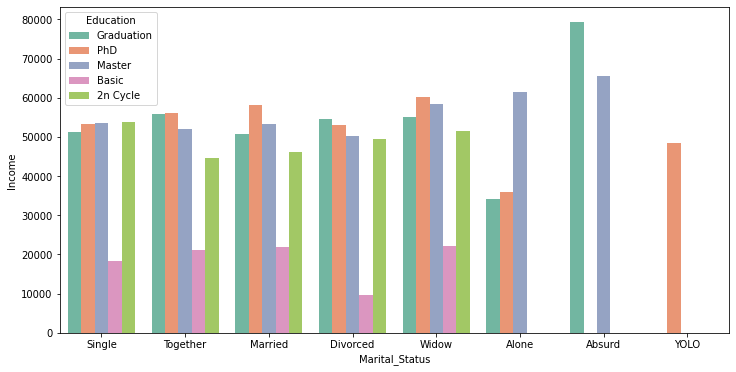

In [ ]:
# Bar chart to visualize customer data
plt.figure(figsize=(12,6))
sns.barplot(x= 'Marital_Status',y='Income',hue='Education',data=new_df, ci=0,palette='Set2')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 97.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 96.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 95.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 94.7% of the points cannot be placed; y

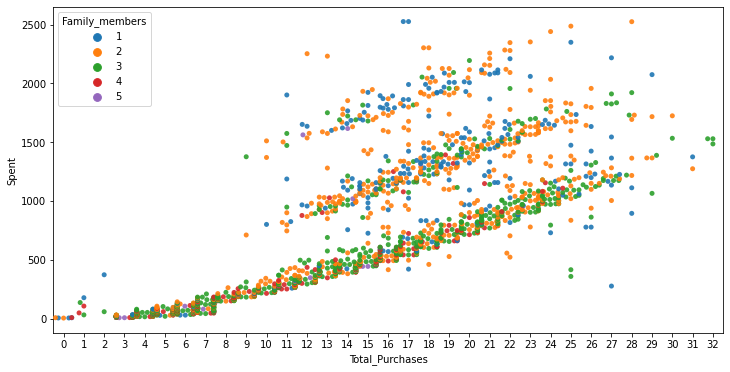

In [ ]:
# Specific scatter plot of customer data
plt.figure(figsize=(12,6))
sns.swarmplot(x=_df["Total_Purchases"], y=_df["Spent"], alpha=0.9, hue= _df['Family_members'] )

In [ ]:
# Use Kmeans to find the best number of clusters
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_ = pd.DataFrame(elbow_data)
df_.head()

,k,inertia
0,1,1.404800e+12
1,2,6.749297e+11
2,3,3.197179e+11
3,4,1.835005e+11
4,5,1.225844e+11


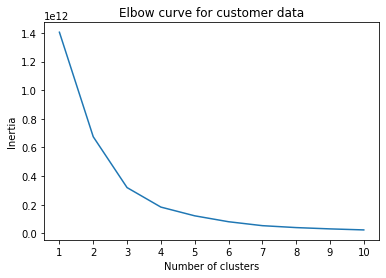

In [ ]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_['k'], df_['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for customer data')
plt.show()

In [ ]:
 # Find the clusters
 def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [ ]:
clusters = get_clusters(5, _df)

In [ ]:
# Plot the clusters based on family member size and total amount spent
def show_clusters(df):
    plt.scatter(df['Family_members'], df['Spent'], c=df['class'])
    plt.xlabel('Family_members')
    plt.ylabel('Spent')
    plt.show()

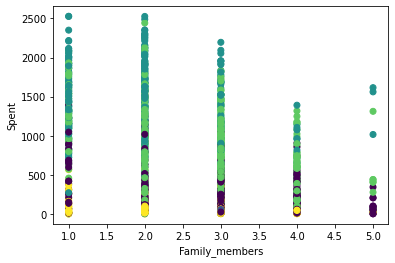

In [ ]:
show_clusters(clusters)

In [ ]:
# Plot the clusters based on income and spent
def show_clusters(df):
    plt.scatter(df['Income'], df['Spent'], c=df['class'])
    plt.xlabel('Income')
    plt.ylabel('Spent')
    plt.show()

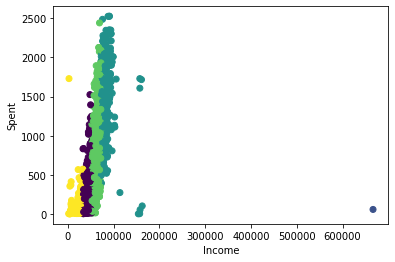

In [ ]:
show_clusters(clusters)

In [ ]:
# Plot clusters based on spent and total purchases
def show_clusters(df):
    plt.scatter(df['Spent'], df['Total_Purchases'], c=df['class'])
    plt.xlabel('Spent')
    plt.ylabel('Total_Purchases')
    plt.show()

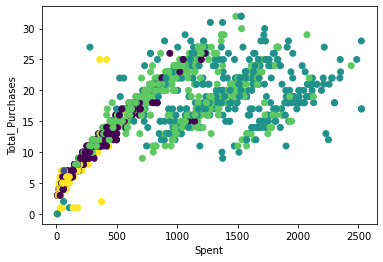

In [ ]:
show_clusters(clusters)

In [ ]:
# Convert categorical data to numeric with `pd.get_dummies`
dummy_df = pd.get_dummies(clean_df)
dummy_df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,1,1,58138.0,0,0,58,635,88,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,1,1,46344.0,1,1,38,11,1,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,1,2,71613.0,0,0,26,426,49,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,1,2,26646.0,1,0,26,11,4,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,2,2,58293.0,1,0,94,173,43,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,1,2,61223.0,0,1,46,709,43,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,2,2,64014.0,2,1,56,406,0,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,1,1,56981.0,0,0,91,908,48,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,3,2,69245.0,0,1,8,428,30,...,3,0,0,0,0,0,0,3,11,0


In [ ]:
 # Split our preprocessed data into our features and target arrays
y = dummy_df["Response"]
X = dummy_df.drop(["Response"],axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [ ]:
# Get the R-squared/R-Score
# Train the linear regression model
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

# print score
r2_score(y, y_pred)

0.3068549761233891

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
 

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 30
hidden_nodes_layer2 = 20

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))


# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                840       
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,481
Trainable params: 1,481
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
52/52 [==============================] - 1s 2ms/step - loss: 0.4978 - accuracy: 0.7996
Epoch 2/100
52/52 [==============================] - 0s 2ms/step - loss: 0.3791 - accuracy: 0.8586
Epoch 3/100
52/52 [==============================] - 0s 2ms/step - loss: 0.3324 - accuracy: 0.8736
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 0.3035 - accuracy: 0.8742
Epoch 5/100
52/52 [==============================] - 0s 2ms/step - loss: 0.2873 - accuracy: 0.8815
Epoch 6/100
52/52 [==============================] - 0s 2ms/step - loss: 0.2731 - accuracy: 0.8869
Epoch 7/100
52/52 [==============================] - 0s 2ms/step - loss: 0.2626 - accuracy: 0.8899
Epoch 8/100
52/52 [==============================] - 0s 2ms/step - loss: 0.2533 - accuracy: 0.9001
Epoch 9/100
52/52 [==============================] - 0s 2ms/step - loss: 0.2458 - accuracy: 0.9013
Epoch 10/100
52/52 [==============================] - 0s 2ms/step - loss: 0.2409 - accuracy: 0.9025
Epoch 11/

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

18/18 - 0s - loss: 0.4941 - accuracy: 0.8700 - 170ms/epoch - 9ms/step
Loss: 0.49406498670578003, Accuracy: 0.8700361251831055


In [ ]:
# Configuration for RDS instance
mode="append"
jdbc_url = "jdbc:postgresql://shopping.cewyyswlridi.us-east-1.rds.amazonaws.com:5432/shopping"
config = {"user":"root",
          "password": "shoppingfour",
          "driver":"org.postgresql.Driver"}

In [ ]:
# Create Spark DataFrame
sparkDF=spark.createDataFrame(dummy_df)

In [ ]:
# Visualize the DataFrame
sparkDF.show(10)

+----+----------+---------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
|  ID|Year_Birth|Education|Marital_Status| Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+----+----------+---------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+-------

In [ ]:
# Pass data to SQL table
sparkDF.write.jdbc(url=jdbc_url, table='clean_shopping', mode=mode, properties=config)